In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
class Formula:
    def __init__(self, dep_var='A3',
                 factors=['C', 'I(C**2)', 'I(C*Mn)', 'I(C*Si)', 'I(C*Cr)', 'I(C*Ni)',
                          'Mn', 'I(Mn**2)', 'I(Mn*Si)', 'I(Mn*Cr)', 'I(Mn*Ni)',
                          'Si', 'I(Si*Si)', 'I(Si*Cr)', 'I(Si*Ni)',
                          'Cr', 'I(Cr**2)', 'I(Cr*Ni)',
                          'Ni', 'I(Ni**2)']):
        self.dep_var = dep_var
        self.factors = factors.copy()

    def dropfactors(self, drop=[]):
        if isinstance(drop, str):
            drop = [drop]

        for factor in drop:
            factor = factor.replace(' ', '')
            self.factors.remove(factor)

    @property
    def formula(self):
        formula = '{} ~ '.format(self.dep_var)
        formula += ' + '.join(self.factors)

        return formula

In [4]:
def filter_factors_by_pvalue(results, maxpvalue=.05):
    pvalues = results.pvalues.sort_values(ascending=False)
    return list(pvalues.index[pvalues > maxpvalue])

In [5]:
dataset = load_dataset('../databases/Tcritical.csv')
dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.000100,NaN,NaN,911.65,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.750075,NaN,NaN,880.26,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,1.500050,NaN,NaN,853.25,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,2.250025,NaN,NaN,829.60,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,3.000000,NaN,NaN,808.65,hipo


In [6]:
# filter dataset
criteria = dataset.eutectoid == 'hipo'
filtered_dataset = dataset[criteria]
filtered_dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.000100,NaN,NaN,911.65,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,0.750075,NaN,NaN,880.26,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,1.500050,NaN,NaN,853.25,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,2.250025,NaN,NaN,829.60,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.0001,0.0001,0.0001,3.000000,NaN,NaN,808.65,hipo


In [7]:
# dependent variable
dep_var = 'A3'

# maximum accepted p-value
maxpvalue = .01

# initialize formula
poly_2nd_deg = Formula(dep_var)
print(poly_2nd_deg.formula)

# initialize regression; ols stands for 'ordinary least squares'
reg = smf.ols(poly_2nd_deg.formula, data=filtered_dataset)
# fit
results = reg.fit()
# print(results.summary())
it = 0

# get factors with pvalue > maxpvalue
dropfactors = filter_factors_by_pvalue(results, maxpvalue)

while len(dropfactors) > 0:
    # drop factors with p-value > maxpvalue
    poly_2nd_deg.dropfactors(dropfactors[0])
    print(dropfactors[0], 'dropped')

    reg = smf.ols(poly_2nd_deg.formula, data=filtered_dataset)
    results = reg.fit()
    # print(results.summary())
    it += 1

    dropfactors = filter_factors_by_pvalue(results, maxpvalue)

print('{} iteration(s)'.format(it))
print(results.summary())

A3 ~ C + I(C**2) + I(C*Mn) + I(C*Si) + I(C*Cr) + I(C*Ni) + Mn + I(Mn**2) + I(Mn*Si) + I(Mn*Cr) + I(Mn*Ni) + Si + I(Si*Si) + I(Si*Cr) + I(Si*Ni) + Cr + I(Cr**2) + I(Cr*Ni) + Ni + I(Ni**2)
I(Cr ** 2) dropped
1 iteration(s)
                            OLS Regression Results                            
Dep. Variable:                     A3   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     6148.
Date:                Wed, 05 Sep 2018   Prob (F-statistic):               0.00
Time:                        19:48:36   Log-Likelihood:                -8523.4
No. Observations:                2308   AIC:                         1.709e+04
Df Residuals:                    2288   BIC:                         1.720e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                               

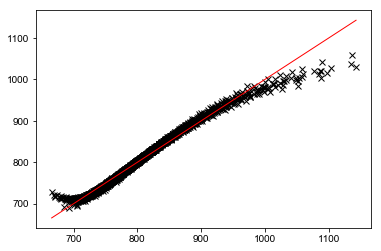

In [8]:
fig, ax = plt.subplots()

exp = reg.endog
pred = results.predict()
ax.plot(exp, pred, 'kx')
ax.plot([exp.min(), exp.max()], [exp.min(), exp.max()], 'r-')